In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [3]:
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [4]:
train_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
nan_counts = train_df.isnull().sum()
nan_columns = nan_counts[nan_counts > 0]

print(nan_columns)

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [6]:
train_df = train_df.drop('Id', axis=1)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [8]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

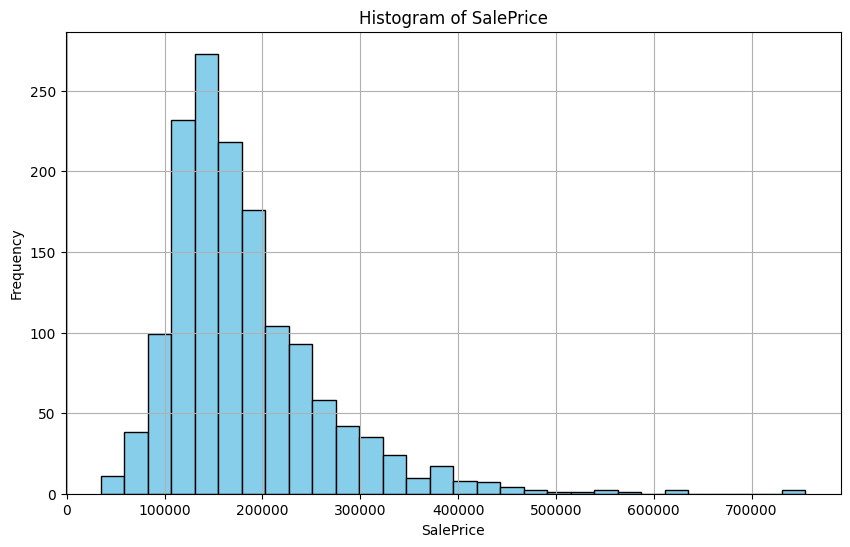

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(train_df['SalePrice'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Using Random Forest**

In [ ]:
train_df_split, valid_df_split = train_test_split(train_df, test_size=0.3, random_state=42)

In [ ]:
label = 'SalePrice'
train_df_split = tfdf.keras.pd_dataframe_to_tf_dataset(train_df_split, label=label, task = tfdf.keras.Task.REGRESSION)
valid_df_split = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df_split, label=label, task = tfdf.keras.Task.REGRESSION)

In [ ]:
# Define and train the model
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model.compile(metrics=["mae", "mse"])

In [ ]:
model.fit(x=train_df_split)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

In [ ]:
evaluation = model.evaluate(x=valid_df_split,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

In [ ]:
ids = test_df.pop('Id')

test_df = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_df,
    task = tfdf.keras.Task.REGRESSION)

preds = model.predict(test_df)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.to_csv('my_submission.csv', index=False)

**Using XGBoost**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import matthews_corrcoef
import numpy as np
from category_encoders.target_encoder import TargetEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
X = train_df.drop(['SalePrice'], axis=1)
y = train_df['SalePrice']

X = pd.get_dummies(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

In [ ]:
y_val_pred = xgb_model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on validation set: {mse}")

In [ ]:
test_ids = test_df['Id']
test_df = test_df.drop('Id', axis=1)
X_test = pd.get_dummies(test_df)

In [ ]:
X_test = X_test.reindex(columns=X.columns, fill_value=0)

test_preds = xgb_model.predict(X_test)

output = pd.DataFrame({'Id': test_ids, 'SalePrice': test_preds})

output.to_csv('my_submission.csv', index=False)